# Pymaceuticals
*Created by Dale Currigan, April 2021*
  
**Instructions:**  
  
Select *Restart & Run All* from the Kernel menu  
Then scroll down or use the navigation links below:  

[Observations & Insights](#observations)    
[Exploratory Data Analysis and Cleaning](#exploration)   
[Summary Statistics](#summary)  
[Bar and Pie Charts](#bar_pie)  
[Quartiles, Outliers and Boxplots](#quartile)  
[Line and Scatter Plots](#line)  
[Correlation and Regression](#cor_reg)  

<a id='observations'></a>
## Observations and Insights 

1. Baseline characterisics were similar between Drug Regimen groups with a large number of data points for all drugs (allowing fair assessment of drug effect) and an even spread of male:female mice overall. However, Male:Female ratio's within treatment groups were not assessed as part of this analysis 
2. The summary statistics table reveals a broad range of tumor responses to the different drug regimens. Ketapril, Naftisol and Stelasyn all had similar median tumor volumes to the placebo control. Their results also showed greater variance. It can be inferred that these drugs are ineffective, at least in the dosing regimen used in this study. 
3. Capomulin and Ramicane were the two most promising treatments with statistically robust results. Median final tumor volume was lowest with these drugs, with a narrow interquartile range and no outliers identified (using 1.5xIQR to define limits)
4. A positive correlation exists between mouse weight and average tumor volume. Pearson correlation was high (0.84) suggesting a fairly strong relationship.  From this finding it could be inferred that mice with low weight have superior treatment response to Capolmulin compared to higher weight mice. 

<a id='exploration'></a>
## Exploratory Data Analysis and Cleaning

In [1]:
# Import Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as st
from scipy.stats import linregress

# Study data file paths
mouse_metadata_path = "data/Mouse_metadata.csv"
study_results_path = "data/Study_results.csv"

# Read the mouse data and the study results
mouse_metadata = pd.read_csv(mouse_metadata_path)
study_results = pd.read_csv(study_results_path)

# Combine the data into a single dataset
df = pd.merge(mouse_metadata, study_results, on="Mouse ID" )

# Display the data table for preview
df.head()

,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [2]:
# Checking the number of mice.
unique_mice = df['Mouse ID'].unique()
num_unique_mice = len(df['Mouse ID'].unique())

print(f"Number of unique mice is: {num_unique_mice}")

Number of unique mice is: 249


In [3]:
# Get the duplicate mice by ID number that shows up for Mouse ID and Timepoint. 

# Iterate through each mouses data  
# If there are no duplicates then the index length and unique timepoints length should be the same  
 
duplicate_ids = []
for mouse in unique_mice:
    
    mouse_data = df[df["Mouse ID"] == mouse]
    if len(mouse_data.index) != len(mouse_data["Timepoint"].unique()):
        duplicate_ids.append(mouse)
               
print(f"Mouse ID with duplicate time points: {duplicate_ids}")


Mouse ID with duplicate time points: ['g989']


In [4]:
# Optional: Get all the data for the duplicate mouse ID. 
removed_data = pd.DataFrame()
for ids in duplicate_ids:
    removed_data = removed_data.append(df[df ['Mouse ID'] == ids], sort=False)

print("Data removed from the the main data set due to duplicate time points:")
display(removed_data)


Data removed from the the main data set due to duplicate time points:


,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
908,g989,Propriva,Female,21,26,0,45.000000,0
909,g989,Propriva,Female,21,26,0,45.000000,0
910,g989,Propriva,Female,21,26,5,48.786801,0
911,g989,Propriva,Female,21,26,5,47.570392,0
912,g989,Propriva,Female,21,26,10,51.745156,0
913,g989,Propriva,Female,21,26,10,49.880528,0
914,g989,Propriva,Female,21,26,15,51.325852,1
915,g989,Propriva,Female,21,26,15,53.442020,0
916,g989,Propriva,Female,21,26,20,55.326122,1
917,g989,Propriva,Female,21,26,20,54.657650,1


In [5]:
# Create a clean DataFrame by dropping the duplicate mouse by its ID.
for ids in duplicate_ids:
    df = df[df ['Mouse ID'] != ids]

print("Data with duplicate timepoints has now been removed from the main DataFrame")
df.head()    

Data with duplicate timepoints has now been removed from the main DataFrame


,Mouse ID,Drug Regimen,Sex,Age_months,Weight (g),Timepoint,Tumor Volume (mm3),Metastatic Sites
0,k403,Ramicane,Male,21,16,0,45.000000,0
1,k403,Ramicane,Male,21,16,5,38.825898,0
2,k403,Ramicane,Male,21,16,10,35.014271,1
3,k403,Ramicane,Male,21,16,15,34.223992,1
4,k403,Ramicane,Male,21,16,20,32.997729,1


In [6]:
# Checking the number of mice in the clean DataFrame.
unique_mice = df['Mouse ID'].unique()
num_unique_mice = len(df['Mouse ID'].unique())

print(f"Number of unique mice in the clean DataFrame is: {num_unique_mice}")
print("")

Number of unique mice in the clean DataFrame is: 248



<a id='summary'></a>
## Summary Statistics

In [7]:
# Generate a summary statistics table of mean, median, variance, standard deviation, and SEM of the tumor volume for each regimen
summary_stats = df.groupby('Drug Regimen').agg(Mean=('Tumor Volume (mm3)', 'mean'), Median=('Tumor Volume (mm3)', 'median'),
                                               Var=('Tumor Volume (mm3)', 'var'), Std_Dev=('Tumor Volume (mm3)', 'std'), 
                                               SEM=('Tumor Volume (mm3)', 'sem'))

# Format and display
summary_stats.iloc[:,0:] = round(summary_stats.iloc[:,0:],4)
print("")
print("Summary stats for tumor volume (units = mm3), for each drug regimen:")
summary_stats.rename(columns={"Mean":"Mean Tumor Vol", "Median":"Median Tumor Vol", "Var":"Tumor Vol Variance",
                              "Std_Dev":"Tumor Vol Std Dev", "SEM":"Tumor Vol SEM"}, inplace=True)
summary_stats.reset_index()


Summary stats for tumor volume (units = mm3), for each drug regimen:


,Drug Regimen,Mean Tumor Vol,Median Tumor Vol,Tumor Vol Variance,Tumor Vol Std Dev,Tumor Vol SEM
0,Capomulin,40.6757,41.5578,24.9478,4.9948,0.3293
1,Ceftamin,52.5912,51.7762,39.2902,6.2682,0.4698
2,Infubinol,52.8848,51.8206,43.1287,6.5672,0.4922
3,Ketapril,55.2356,53.6987,68.5536,8.2797,0.6039
4,Naftisol,54.3316,52.5093,66.1735,8.1347,0.5965
5,Placebo,54.0336,52.2889,61.1681,7.8210,0.5813
6,Propriva,52.3209,50.4463,43.8520,6.6221,0.5443
7,Ramicane,40.2167,40.6732,23.4867,4.8463,0.3210
8,Stelasyn,54.2331,52.4317,59.4506,7.7104,0.5731
9,Zoniferol,53.2365,51.8185,48.5334,6.9666,0.5164


<a id='bar_pie'></a>
## Bar and Pie Charts

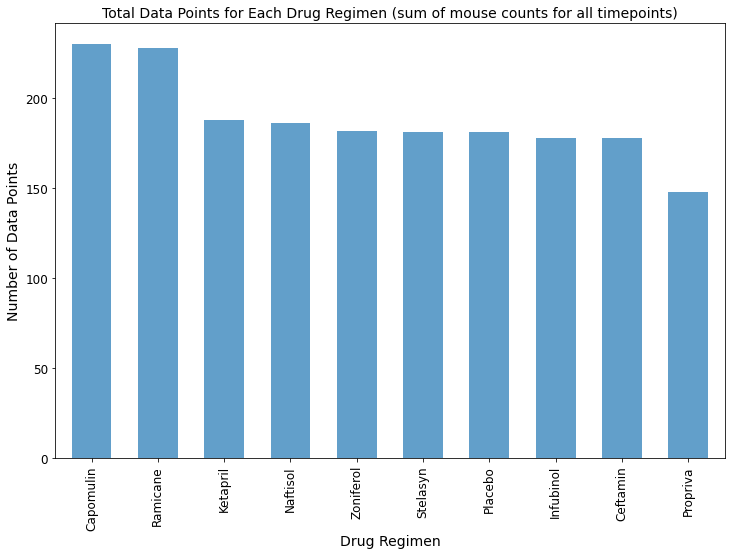

In [8]:
# -- BAR PLOT USING PANDAS -- #

# Get the relevant data by grouping by drug regimen, counting and sorting 
plot_data = df.groupby(["Drug Regimen"])["Mouse ID"].count()
plot_data = plot_data.sort_values(ascending=False)

# Bar plot showing the total number of mice for each treatment
plot = plot_data.plot.bar(figsize=(12,8), width=0.6, alpha=0.7, fontsize=12)

# Format and Display
plot.set_ylabel("Number of Data Points", fontsize=14)
plot.set_xlabel("Drug Regimen", fontsize=14)
plot.set_title("Total Data Points for Each Drug Regimen (sum of mouse counts for all timepoints)", fontsize=14)
plt.show()

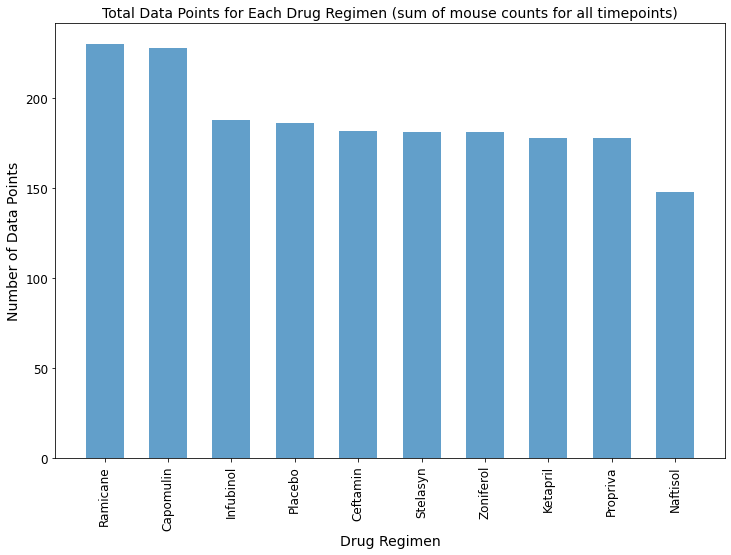

In [9]:
# -- BAR PLOT USING PYPLOT -- #

# Set the x-axis labels (plot_data from previous cell will be used for mouse counts) 
x_axis = df["Drug Regimen"].unique()

# Bar plot showing the total number of mice for each treatment
plt.subplots(figsize=(12,8))
plt.bar(x_axis, plot_data, width=0.6, alpha=0.7)

# Format and Display
plt.xlabel("Drug Regimen", fontsize=14)
plt.ylabel("Number of Data Points", fontsize=14)
plt.xticks(rotation='vertical', fontsize=12)
plt.yticks(fontsize=12)
plt.title("Total Data Points for Each Drug Regimen (sum of mouse counts for all timepoints)", fontsize=14)
plt.show()

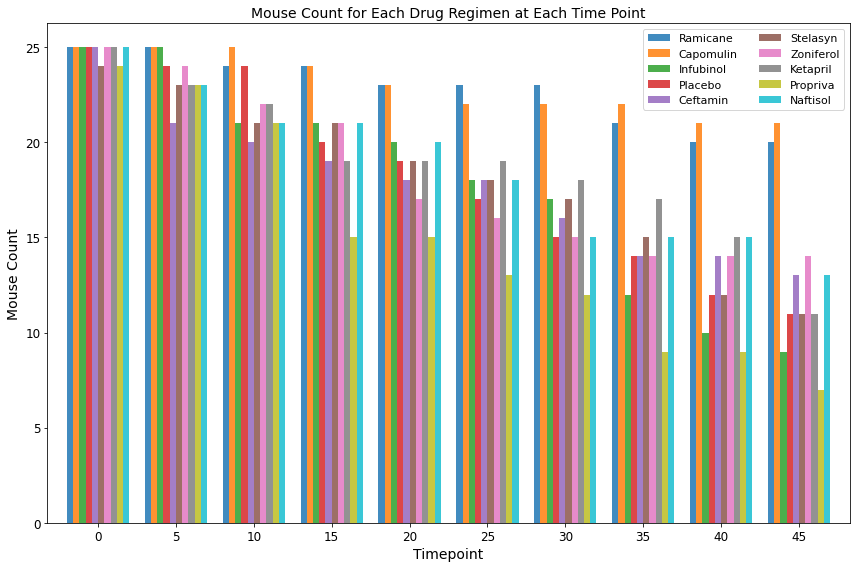

In [10]:
# -- BAR PLOT USING PANDAS -- #

# Create a dataframe with only the unique Timepoints
plot_data = pd.DataFrame({"Timepoint":df['Timepoint'].unique()})

# Iterate throught the drug regimens, grouping their data by timepoint and counting number of mice
for treatment in df['Drug Regimen'].unique():
    data = df[df['Drug Regimen'] == treatment].groupby(['Timepoint'])['Mouse ID'].nunique().reset_index()
    plot_data[treatment] = data['Mouse ID']

# Plot the resulting DataFrame using Pandas.plot
mouse_plot = plot_data.plot.bar(x="Timepoint", figsize=(12,8), rot="horizontal", width=0.8,
                                alpha=0.85, legend=True, fontsize=12)

mouse_plot.set_ylabel("Mouse Count", fontsize=14)
mouse_plot.set_xlabel("Timepoint", fontsize=14)
mouse_plot.set_title("Mouse Count for Each Drug Regimen at Each Time Point", fontsize=14)
plt.tight_layout()
plt.legend(ncol=2, fontsize=11)

plt.show()

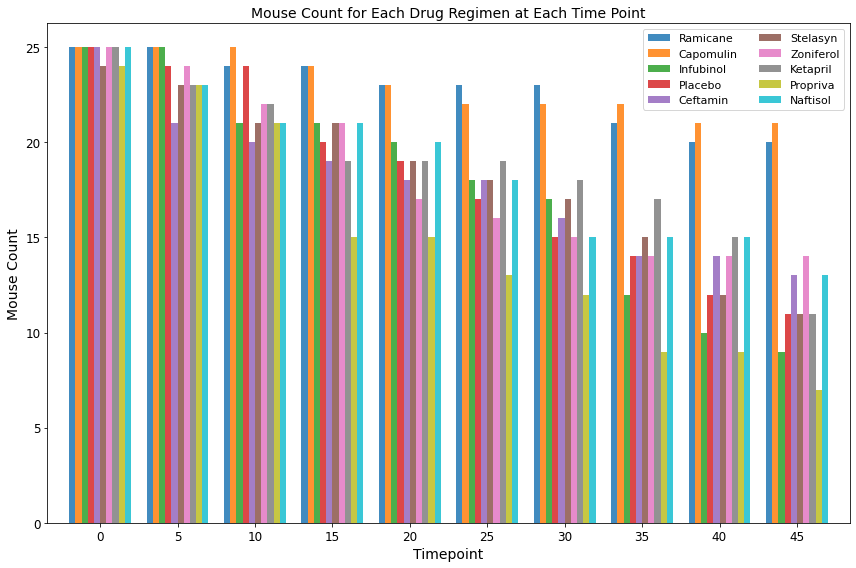

In [11]:
# -- BAR PLOT USING PYPLOT -- #

# x-axis set to the unique values in the 'Timepoint' column of the plot_data DataFrame
x_axis = plot_data['Timepoint'].unique()
# width of each bar specified (needed for spacing of bars)
bar_width = 0.4

# PLOT THE BARS
fig, ax = plt.subplots(figsize=(12,8))

# Iterate through columns of plot_data (each colulmn is a different drug regimen)
#   plot that drug regimens data, allowing for a spacing (= to bar_width) so that bars don't overlap 
for col in range(1, len(plot_data.columns)):
    ax.bar([x + (bar_width*col) for x in x_axis], plot_data.iloc[:,col], width=0.4, alpha=0.85, label=plot_data.columns[col])

# FORMATTING AND DISPLAY
ax.legend(ncol=2, fontsize=11)
plt.xlabel("Timepoint", fontsize=14)
plt.ylabel("Mouse Count", fontsize=14)
plt.title("Mouse Count for Each Drug Regimen at Each Time Point", fontsize=14)
plt.xlim()
plt.xticks(ticks=(x_axis+2.2), labels=plot_data['Timepoint'].unique(), fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(min(x_axis)-(bar_width*3), max(x_axis)+bar_width*14)
plt.tight_layout()
plt.show()


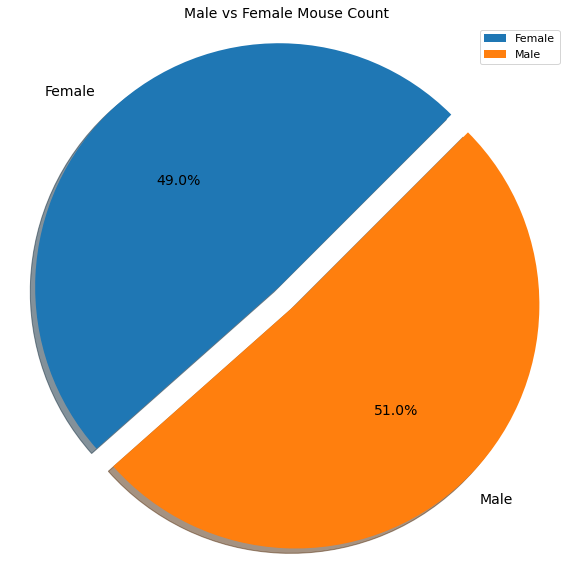

In [12]:
# -- PIE PLOT USING PANDAS -- #

# Group data by sex using Pandas groupby
plot_data_2 = df.groupby(['Sex']).count()

# Plot the data as a Pandas plot pie chart
plot = plot_data_2.plot.pie(y='Mouse ID', startangle=45, figsize=(10,10), 
                            autopct='%1.1f%%', shadow=True, fontsize=14, 
                            # dynamically determine element that has the greatest value and apply explode 
                            # This statement returns an array of booleans which is multipled by the explode factor 
                            explode=(plot_data_2['Mouse ID'] == max(plot_data_2['Mouse ID'])) * 0.1)

plt.axis("equal")
plot.set_title("Male vs Female Mouse Count", fontsize=14)
plt.legend(fontsize=11)
plt.ylabel('')
plt.show()


<function matplotlib.pyplot.show(*args, **kw)>

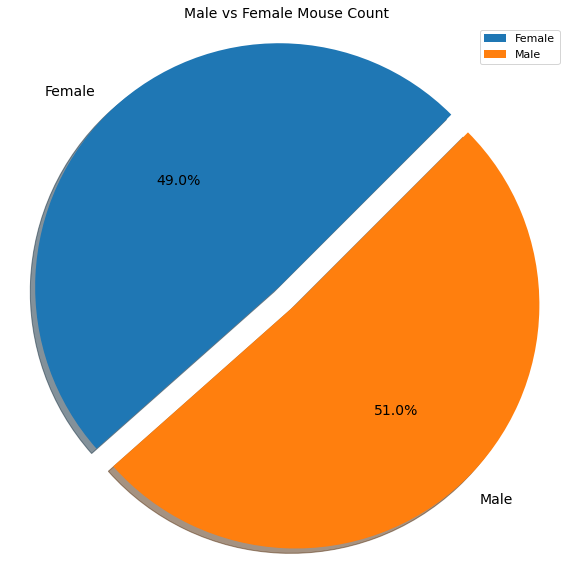

In [26]:
# -- PIE PLOT USING PYPLOT -- #

plt.subplots(figsize=(10,10))

plot_2 = plt.pie(plot_data_2['Mouse ID'], labels=plot_data_2.index, startangle=45, 
         autopct='%1.1f%%', shadow=True, 
         # dynamically determine element that has the greatest value and apply explode 
         # This statement returns an array of booleans which is multipled by the explode factor 
         explode=(plot_data_2['Mouse ID'] == max(plot_data_2['Mouse ID'])) * 0.1)

plt.legend(fontsize=11)
plt.rcParams.update({'font.size': 14})
plt.title("Male vs Female Mouse Count", fontsize=14)
plt.axis("equal")
plt.show

# Run cell again if font sizes don't initially match the pandas pie plot version

<a id='quartile'></a>
## Quartiles, Outliers and Boxplots

In [14]:
# FIRST DETERMINE THE FINAL TUMOR VOLUME FOR EACH MOUSE 

# Calculate the final tumor volume of each mouse across four of the treatment regimens:  
# Capomulin, Ramicane, Infubinol, and Ceftamin

# Create a new df of just the promising treatments 
df2 = df[(df['Drug Regimen'] == 'Capomulin') |
         (df['Drug Regimen'] == 'Ramicane') |
         (df['Drug Regimen'] == 'Infubinol') |
         (df['Drug Regimen'] == 'Ceftamin')]

final_vol = []
treatment = []

# Create a df with Mouse ID, Drug Regimen and Final Tumor Volume for each mouse
for mouse in df2["Mouse ID"].unique():
    data = df2[df2['Mouse ID'] == mouse] # the mouses  data
    final_vol.append(data.iloc[-1, 6]) # the final row, tumor vol column
    treatment.append(data.iloc[-1, 1]) # the final row, drug regimen column
    
drug_data = pd.DataFrame({"Mouse ID":df2["Mouse ID"].unique(),
                         "Drug Regimen":treatment,
                         "Final Tumor Vol":final_vol})

drug_data.sort_values(by="Drug Regimen", inplace=True)
drug_data


,Mouse ID,Drug Regimen,Final Tumor Vol
32,j246,Capomulin,38.753265
36,v923,Capomulin,40.658124
35,w150,Capomulin,39.952347
34,j119,Capomulin,38.125164
39,l509,Capomulin,41.483008
...,...,...,...
46,r921,Ramicane,43.419381
47,w678,Ramicane,43.166373
48,y449,Ramicane,44.183451
23,r811,Ramicane,37.225650


In [27]:
# NEXT CREATE A SUMMARY DATAFRAME BASED ON FINAL TUMOR VOLUME VALUES

# Put treatments into a list for for loop 
treatments = drug_data['Drug Regimen'].unique()

# Create a df to store the summary data
drug_quartiles = pd.DataFrame(columns=("Lower Quartile", "Upper Quartile", "IQR", "Median", 
                                       "Lower Bound", "Upper Bound"), index=treatments)

# Summarise the results data for each drug regimen and display results     
for drug in treatments:
    data = drug_data[drug_data['Drug Regimen'] == drug]
    quartiles = data['Final Tumor Vol'].quantile([.25,.5,.75])
    iqr = quartiles[0.75] - quartiles[0.25]
    
    drug_quartiles.loc[drug, "Median"] = quartiles[0.5]
    drug_quartiles.loc[drug, "Lower Quartile"] = quartiles[0.25]
    drug_quartiles.loc[drug, "Upper Quartile"] = quartiles[0.75]
    drug_quartiles.loc[drug, "IQR"] = iqr
    drug_quartiles.loc[drug, "Lower Bound"] = quartiles[0.25] - (1.5*iqr)
    drug_quartiles.loc[drug, "Upper Bound"] = quartiles[0.75] + (1.5*iqr) 
   
print("Quartiles on the four most promising drugs:")
display(drug_quartiles)
print("")

# LOOK FOR OUTLIERS

# Determine outliers using upper and lower bounds
# Create empty df to store outlier data
outliers = pd.DataFrame(columns=drug_data.columns)

# Iterate through mice, checking if final tumor volume is an outlier
for mouse in drug_data['Mouse ID'].unique():
    mouse_data = drug_data[drug_data['Mouse ID'] == mouse] # get mouses data
    treatment = mouse_data.iloc[-1, 1] # get which drug regimen mouse was on

    # Check if mouse final tumor vol is an outlier, and if so add to the outliers df
    #    --final tumor vol--            --upper bound--                            --final tumor vol--            --lower bound--        
    if (mouse_data.iloc[0,2] > drug_quartiles.loc[treatment, "Upper Bound"]) | (mouse_data.iloc[0,2] < drug_quartiles.loc[treatment, "Lower Bound"]): 
        outliers = outliers.append(mouse_data, ignore_index=True)

print("The following outlier points were identifed in the data:")                  
display(outliers)
    

Quartiles on the four most promising drugs:


,Lower Quartile,Upper Quartile,IQR,Median,Lower Bound,Upper Bound
Capomulin,32.3774,40.1592,7.78186,38.1252,20.7046,51.832
Ceftamin,48.7221,64.2998,15.5778,59.852,25.3554,87.6665
Infubinol,54.0486,65.5257,11.4771,60.1652,36.8329,82.7414
Ramicane,31.5605,40.659,9.09854,36.5617,17.9127,54.3068



The following outlier points were identifed in the data:


,Mouse ID,Drug Regimen,Final Tumor Vol
0,c326,Infubinol,36.321346


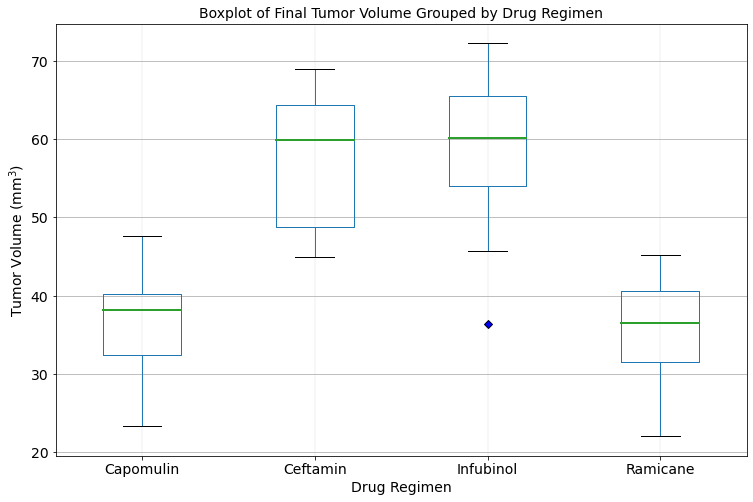

In [16]:
# Generate a box plot of the final tumor volume of each mouse across four regimens of interest

# Create a dictionary to store the outlier and median formatting 
custom_outlier = dict(markerfacecolor='b', marker='D')
median_prop = dict(linewidth=2)

# Create a df containing just the drug regiment and final tumor volume data
plot_data = drug_data[['Drug Regimen', 'Final Tumor Vol']]

# Create 4 boxplots of this data, grouped by drug regimen
plot = plot_data.boxplot(by="Drug Regimen", column="Final Tumor Vol", grid=True, 
                         figsize=(12,8), fontsize=14, flierprops=custom_outlier,
                         medianprops=median_prop)

# Formatting and Display
plot.set_ylabel("Tumor Volume (mm$^{3}$)", fontsize=14)
plot.set_xlabel("Drug Regimen", fontsize=14)
plot.set_title("Boxplot of Final Tumor Volume Grouped by Drug Regimen", fontsize=14)
plot.grid(color='grey', axis='x', linewidth=0.25, alpha=0.5)
plt.suptitle("")
plt.show()


<a id='line'></a>
## Line and Scatter Plots

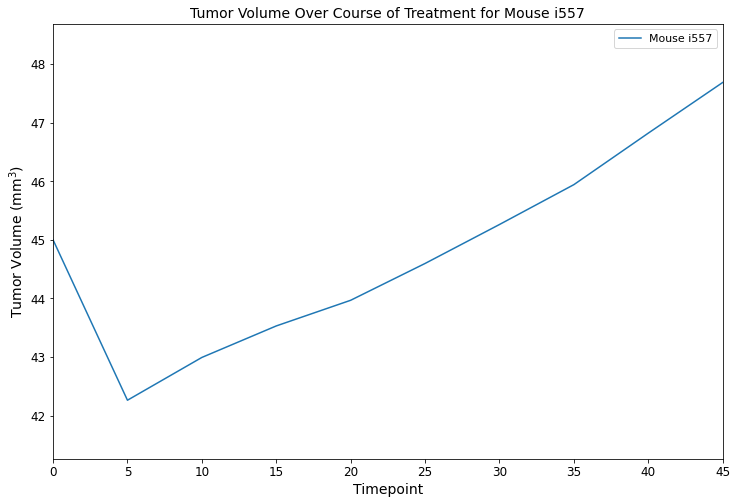

In [17]:
# Generate a line plot of time point versus tumor volume for a mouse treated with Capomulin
# Mouse with ID 'i557' chosen from the data set
plot_mouse = df[df["Mouse ID"] == "i557"] 

# Line plot of this mouses tumor volume vs time
plot = plot_mouse.plot.line(x="Timepoint", y="Tumor Volume (mm3)", figsize=(12,8), label="Mouse i557")

# Formatting and Display
plot.set_ylabel("Tumor Volume (mm$^{3}$)", fontsize=14)
plot.set_xlabel("Timepoint", fontsize=14)
plot.set_title("Tumor Volume Over Course of Treatment for Mouse i557", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=11)
plt.ylim(plot_mouse['Tumor Volume (mm3)'].min()-1, plot_mouse['Tumor Volume (mm3)'].max()+1)
plt.xlim(plot_mouse['Timepoint'].min(), plot_mouse['Timepoint'].max())
plt.show()

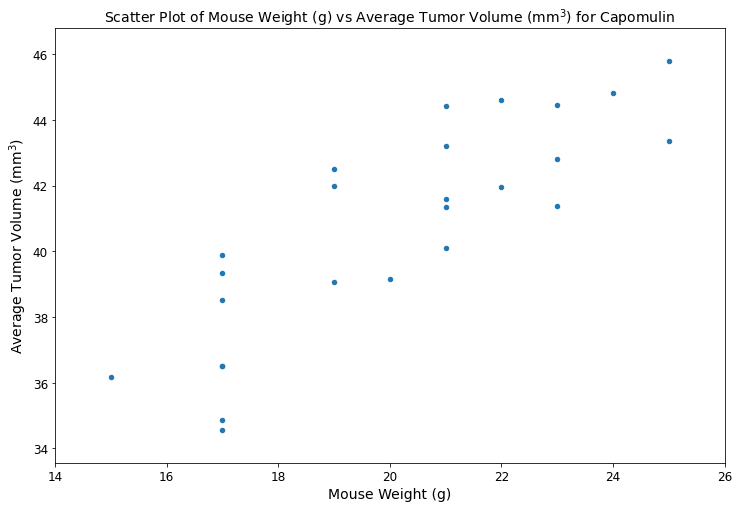

In [18]:
# Generate a scatter plot of mouse weight versus average tumor volume for the Capomulin regimen

# Create a df of just the Capomulin data
cap_data = df[df["Drug Regimen"] == "Capomulin"] 
# Create a lists for average tumor volume, and mouse weight for each mouse in the Capomulin regimen group 
mean_tumor_vol = pd.DataFrame(cap_data.groupby(["Mouse ID"])["Tumor Volume (mm3)"].mean()).reset_index()
weight = pd.DataFrame(cap_data.groupby(["Mouse ID"])["Weight (g)"].max()).reset_index()
# Merge these yielding a df which can be plotted
plot_data = pd.merge(mean_tumor_vol, weight, on="Mouse ID")

# Scatter plot of mouse weight vs tumor volume
plot = plot_data.plot.scatter(x="Weight (g)", y="Tumor Volume (mm3)", figsize=(12,8))

# Formatting and Display
plot.set_ylabel("Average Tumor Volume (mm$^{3}$)", fontsize=14)
plot.set_xlabel("Mouse Weight (g)", fontsize=14)
plot.set_title("Scatter Plot of Mouse Weight (g) vs Average Tumor Volume (mm$^{3}$) for Capomulin", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(plot_data['Tumor Volume (mm3)'].min()-1, plot_data['Tumor Volume (mm3)'].max()+1)
plt.xlim(plot_data['Weight (g)'].min()-1, plot_data['Weight (g)'].max()+1)
plt.show()


<a id='cor_reg'></a>
## Correlation and Regression

In [19]:
# -- CORRELATION -- 
# Calculate the correlation coefficient  

correlation = st.pearsonr(plot_data["Weight (g)"] , plot_data["Tumor Volume (mm3)"])

print(f"The correlation coefficient for mouse weight and average tumor volume is {round(correlation[0],2)}")
print("")


The correlation coefficient for mouse weight and average tumor volume is 0.84



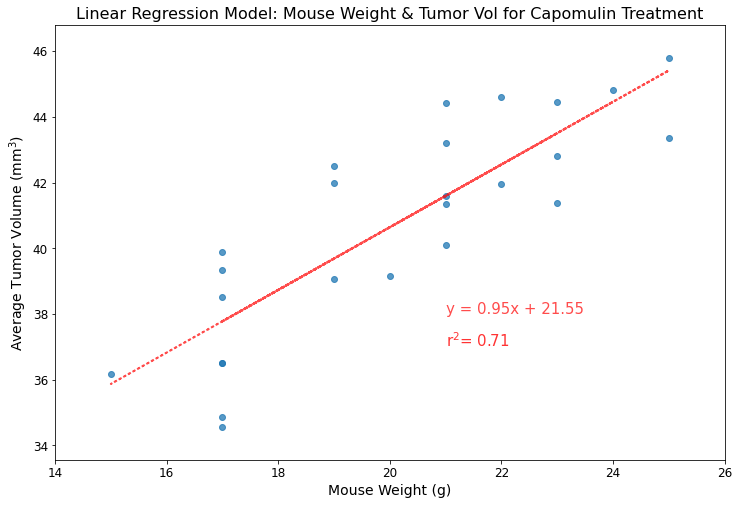

In [20]:
# -- LINEAR REGRESSION --  
# Set x and y values
x_values = plot_data["Weight (g)"]
y_values = plot_data["Tumor Volume (mm3)"]

# Calulate the linear regression equation for the data
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = (x_values * slope) + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
r_square = "r$^{ 2}$= " + str(round(rvalue**2,2))

# Plot the data, regression line and equation
plt.subplots(figsize=(12,8))
plt.scatter(x_values,y_values, alpha=0.75)
plt.plot(x_values,regress_values, linestyle=":", linewidth=2, color="red", alpha=0.7)
plt.annotate(line_eq,(21,38),fontsize=15,color="red", alpha=0.7)
plt.annotate(r_square,(21,37),fontsize=15,color="red", alpha=0.8)

# Formatting and Display
plt.title("Linear Regression Model: Mouse Weight & Tumor Vol for Capomulin Treatment", 
          fontsize=16)
plt.xlabel('Mouse Weight (g)')
plt.ylabel('Average Tumor Volume (mm$^{3}$)')
plt.ylim(y_values.min()-1, y_values.max()+1)
plt.xlim(x_values.min()-1, x_values.max()+1)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()